<a href="https://colab.research.google.com/github/userviktoriuss/doom_style_transfering/blob/main/Doom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix перенос стиля изображения (Style Transfering)*Курсив*

## Замечания, TODO


### TODO:
* перебрать гиперпараметры (LOSSD2_TRESH, K, ...)
* Меньше батчи
* Кэшировать датасеты
* сплитить, чтобы кусочки накладывались (overlap = 1/0.5 - на сколько процентов сдвигаться вправо)

### Референсы
[DCGAN Tensorflow tutor](https://www.tensorflow.org/tutorials/generative/dcgan)<br>
[Style Transfer (medium.com)](https://towardsdatascience.com/style-transfer-with-gans-on-hd-images-88e8efcf3716)<br>

### **Siamese Discriminator:**

there are 2 domains of pictures - A and B. Domain B contains pictures that have the requires style, which is going to be transfered to domain A.

there is an origin vector $v$ of size $K$ (we want it to be zero-vector after the learning process)<br>
*Discriminator goals* 
1. D(B) must be close to $v$
2. D(G(A)) must be far from original point
3. We want D to preserve content, it means that D generates "similar" vectors for A and G(A) 
*Generator goals* 
1. D(G(A)) must be close to the origin
2. the same as 3. for Discriminator - we want the generator to preserve content (like, moves all the vectors proportionally or smth like that)

*So, the losses are:*

lossD1 = lensq(D(B)) <br>
lossD2 = max(0, const - lensq(D(G(A)))) # which cost to choose <br>
lossD3 = cosine_similarity(D(A1) - D(A2), D(G(A1)) - D(G(A2)))

lossG1 = lensq(D(G(A))) <br>
lossG2 = lossD3

<b>Here, for every loss function I use MSE</b>

*Final loss functions*:
lossD = lossD1 + lossD2 + lossD3
lossG = lossG1 + lossG2

## Гиперпараметры и прочие константы

In [ ]:
# Гиперпараметры
K = 40
LOSSD2_THRESH = 13

BATCH_SIZE = 50
BUFFER_SIZE = 50

In [ ]:
S = 64
N_IMAGES_A = 5 # нумерация с 0 до 22
DOMAIN_A_URL = 'https://raw.githubusercontent.com/userviktoriuss/doom_style_transfering/main/domain_A/pic{0}.jpg'

# N_IMAGES_B = 36  # всего их 152, но я взял меньше, чтобы датасеты были сбалансированы
# DOMAIN_B_URL = 'https://raw.githubusercontent.com/userviktoriuss/doom_style_transfering/main/domain_B/pic{0}.jpg'


N_IMAGES_B = 15  # всего их 152, но я взял меньше, чтобы датасеты были сбалансированы
DOMAIN_B_URL = 'https://raw.githubusercontent.com/userviktoriuss/doom_style_transfering/main/vangogh{0}.jpg'

In [ ]:
import numpy as np
import tensorflow as tf
from keras import layers
import PIL
from PIL import Image
import requests
from io import BytesIO
import os
import time
import imageio
import glob
from matplotlib import pyplot as plt
%matplotlib inline

from IPython import display

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
# отрисовка моделей
!pip install visualkeras
import visualkeras

## Подготовим датасеты

### Проверим, что изображение загружается и режется корректно

In [ ]:
# режет объект Image на куски splitS*splitS, которые хранятся в np.array
def split_image(img, splitS):
  pxs =  np.asarray(img, dtype=np.float32)
  height, width, depth = pxs.shape
  n, m = height // splitS, width // splitS
  
  i = 0
  j = 0
  batch = pxs[i * splitS : (i + 1) * splitS, j * splitS : (j + 1) * splitS]
  batch = np.expand_dims(batch, axis=0)
  for i in range(n):
    for j in range(m):
      if i == j == 0:
        continue
      crop = np.expand_dims(
          pxs[i * splitS : (i + 1) * splitS, j * splitS : (j + 1) * splitS], 
          axis = 0)
      batch = np.vstack((batch, crop))
      
  
  batch /= 255
  return batch

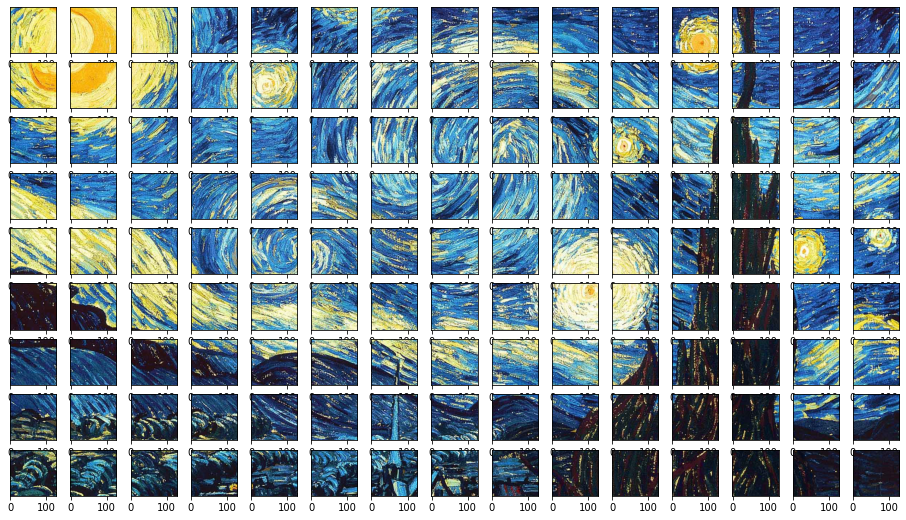

In [ ]:
# Загрузить одну картинку и посмотреть, как она порежется на кусочки
i = 14
image_url = DOMAIN_B_URL.format(i)
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

width, height = img.size
batch = split_image(img, 2 * S)


fig = plt.figure()
fig.set_size_inches(16, 9)

n, m = height // (2 * S), width // (2 * S)
for i in range(n):
  for j in range(m):
    plt.subplot(n, m, i * m + j + 1)
    plt.tick_params(
      axis='y',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      left=False,      # ticks along the bottom edge are off
      right=False,         # ticks along the top edge are off
      labelleft=False) # labels along the bottom edge are off
    # ticks off
    plt.imshow(batch[i * m + j])


plt.show()

### Скачаем, порежем и сложим в Dataset изображения

In [ ]:
# Порежем все картинки и сложим в tf.data.Dataset
def make_dataset_from_url(pics_url, n_images):
    dataset = None
    for i in range(n_images):
        image_url = pics_url.format(i)
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        batch = split_image(img, 2 * S)
        ds1 = tf.data.Dataset.from_tensor_slices(batch)

        if i == 0:
            dataset = ds1
        else:
            dataset = dataset.concatenate(ds1)

    return dataset

#### Вариант 1 - домен B из одной картинки

In [ ]:
# ЕСЛИ ХОТИМ СОСТАВИТЬ ДОМЕН В ЦЕЛИКОМ ИЗ ОДНОЙ КАРТИНКИ (чтобы был более чёткий стиль)
i = 2
image_url = DOMAIN_B_URL.format(i)
img = Image.open(BytesIO(response.content))
batch = split_image(img, 2 * S)
ds = tf.data.Dataset.from_tensor_slices(batch)
for i in range(38):
    ds1 = tf.data.Dataset.from_tensor_slices(batch)
    ds = ds.concatenate(ds1)
dataset_B = ds
dataset_B # не должен быть None

<ConcatenateDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
len(dataset_B) # размер 4620

1950

In [ ]:
dataset_A = make_dataset_from_url(DOMAIN_A_URL, N_IMAGES_A) # 1 min
dataset_A # не должен быть None

<ConcatenateDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
len(dataset_A) # размер 8058

2007

#### Вариант 2 - домен В из много картинок

In [ ]:
# ЕСЛИ ХОТИМ ПОЛОЖИТЬ В ДОМЕН В ВЕСЬ ДАТАСЕТ
dataset_B = make_dataset_from_url(DOMAIN_B_URL, N_IMAGES_B)
dataset_B # не должен быть None

<ConcatenateDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
len(dataset_B) # размер 7920

1538

In [ ]:
dataset_A = make_dataset_from_url(DOMAIN_A_URL, N_IMAGES_A) # 1 min
dataset_A # не должен быть None

<ConcatenateDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
len(dataset_A) # размер 8058

2007

#### Вариант 3 - домен А равен домену В (запускать после вар1 или вар2)

In [ ]:
# TEST ONLY
dataset_A = dataset_B.take(len(dataset_B))

In [ ]:
len(dataset_A) # размер 8058

1050

### Настроим датасеты

In [ ]:
dataset_A = dataset_A.shuffle(BUFFER_SIZE)
dataset_B = dataset_B.shuffle(BUFFER_SIZE)
dataset_A = dataset_A.batch(BATCH_SIZE)
dataset_B = dataset_B.batch(BATCH_SIZE)

In [ ]:
dataset_A = dataset_A.take(len(dataset_A) - 1) # в последнем батче меньше, чем BATCH_SIZE элементов. 
dataset_B = dataset_B.take(len(dataset_B) - 1) # Удалим по последнему, чтобы складывать массивы одинаковых размеров

In [ ]:
print(len(dataset_A)) 
print(len(dataset_B))

40
30


## Нейросеть

### Пропишем модели

#### Генератор

In [ ]:
# Модель будет генерировать изображение размера s * s
# понижает, а затем повышает размерность изображения
# цель - выделить главную информацию при кодировании и отрисовать её в нужном стиле при декодировании
def make_generator_model():
    model = tf.keras.Sequential()
    #way down we go
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[S, S, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, 64)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 128)

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 4, 4, 512)

    # way up we go
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [ ]:
# Закоммментирован код для проверки генератора до обучения

#batch = None # get from batch somehow)))
#for b in dataset_B.take(1):
#  batch = b.numpy()
#image = batch[0]
#plt.imshow(image)

In [ ]:
# проверим работу генератора
generator = make_generator_model()

#generated_image = generator(batch, training=False)
#plt.imshow(generated_image[0])

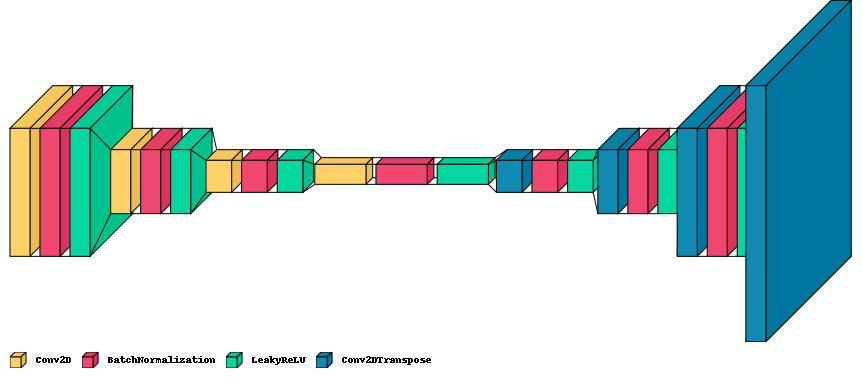

In [ ]:
visualkeras.layered_view(generator,legend=True, draw_volume=True)

#### Дискриминатор

In [ ]:
# Модель будет обучена сопостовлять картинке вектор размерности K
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[2 * S, 2 * S, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(70)) # ну или не 70
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(K)) # ещё один dense, чтобы строить более сложные векторы

    return model

In [ ]:
discriminator = make_discriminator_model()
#decision = discriminator(generated_image)
#decision[0]

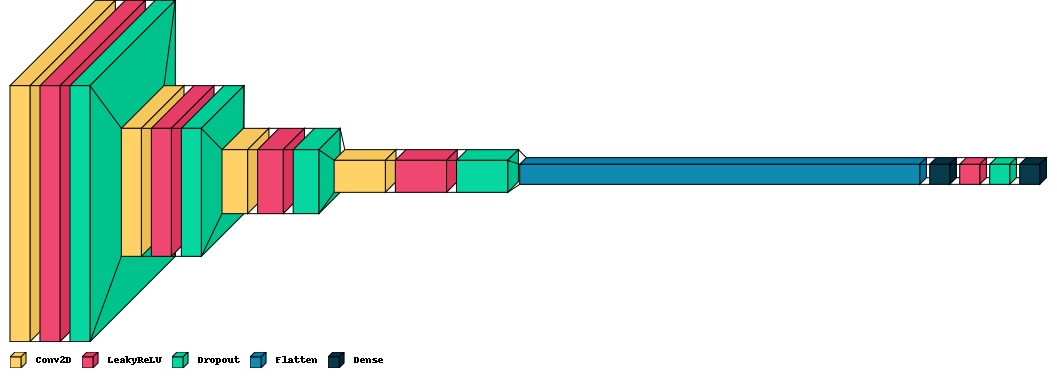

In [ ]:
import visualkeras
visualkeras.layered_view(discriminator,legend=True, draw_volume=True)

#### Функции потерь

In [ ]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # what if false??
mse = tf.keras.losses.MeanSquaredError()

Функция потерь дискриминатора <br>
lossD1 = lensq(D(B)) <br>
lossD2 = max(0, const - lensq(D(G(A)))) # which cost to choose <br>
lossD3 = cosine_similarity(D(A1) - D(A2), D(G(A1)) - D(G(A2))) <br>

In [ ]:
#def discriminator_loss_old(real_output, fake_output):
#    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#    total_loss = real_loss + fake_loss
#    return total_loss

# возвращает квадрат длины вектора
def lensq(v):
  return tf.math.reduce_sum(v ** 2) # add_n

def lossD1(db):
    return mse(tf.zeros_like(db), lensq(db))

def lossD2(dga):
    return mse(tf.zeros_like(dga), tf.math.maximum(tf.zeros_like(dga), LOSSD2_THRESH - lensq(dga))) # tf.math.maximum

def lossD3(da1, da2, dga1, dga2):
    v2 = -tf.keras.losses.cosine_similarity(da1 - da2, dga1 - dga2, axis=1)
    v1 = tf.ones_like(v2)
    return mse(v1, v2) # tf.math.abs


# размеры da1, da2, dga1, dga2, и размеры dga1 и dga2 в сумме дадут dga
def discriminator_loss(db, dga, da1, da2, dga1, dga2):
    return lossD1(db) + lossD2(dga) + lossD3(da1, da2, dga1, dga2)

Функция потерь генератора <br>
lossG1 = lensq(D(G(A))) <br>
lossG2 = lossD3 <br>

In [ ]:
def lossG1(dga):
    return mse(tf.ones_like(dga), lensq(dga))

def lossG2(da1, da2, dga1, dga2):
    v2 = tf.math.abs(tf.keras.losses.cosine_similarity(da1 - da2, dga1 - dga2, axis=1))
    v1 = tf.ones_like(v2)
    #print(v1.shape, v2.shape)
    print(da1)
    return mse(v1, v2) # tf.math.abs

def generator_loss(dga, da1, da2, dga1, dga2):
    return lossG1(dga) + lossG2(da1, da2, dga1, dga2)

#def generator_loss_old(fake_output):
#    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Оптимизаторы

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5) # 1e-4 # можно 1е6 попробовать
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5) # 1e-4

#### Сохранение контрольных точек

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Настроим цикл обучения

In [ ]:
from matplotlib.cm import datad
@tf.function
def train_step(images_tuple):
    a, b = images_tuple
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # разделим картинки на 4 штуки размера S*S
      a1 = a[:, :S, :S]
      a2 = a[:, :S, S:]
      a3 = a[:, S:, :S]
      a4 = a[:, S:, S:]
      #print(a1.shape)
      #print(a2.shape)
      #print(a3.shape)
      #print(a4.shape)

      # получим 4 сгенерированных картинки S*S
      ga1 = generator(a1, training=True)
      ga2 = generator(a2, training=True)
      ga3 = generator(a3, training=True)
      ga4 = generator(a4, training=True)

      # cоберём их в одну картинку S*S
      ga_row1 = tf.concat([ga1, ga2], axis=2)
      ga_row2 = tf.concat([ga3, ga4], axis=2)
      ga = tf.concat([ga_row1, ga_row2], axis=1)

      # дальше как раньше
      db = discriminator(b, training=True)
      da = discriminator(a, training=True)
      dga = discriminator(ga, training=True)

      n = len(da)
      k = n // 2

      da1 = da[:k] #
      da2 = da[-k:] #

      dga1 = dga[:k] #
      dga2 = dga[-k:] #

      gen_loss = generator_loss(dga, da1, da2, dga1, dga2)
      disc_loss = discriminator_loss(db, dga, da1, da2, dga1, dga2)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss

In [ ]:
import time
def train(A_dataset, B_dataset, epochs):
    test_inp = None
    for aaa in A_dataset.take(1):
        test_inp = aaa.numpy()
    test_inp = test_inp[:16]

    for epoch in range(epochs):
        start = time.time()

        i = 0
        sum_loss = 0
        for B_batch in B_dataset:
            for A_batch in A_dataset.take(1):
                A_numpy = A_batch.numpy()
                B_numpy = B_batch.numpy()
                lenA = len(A_numpy)
                lenB = len(B_numpy)

                if lenA == BATCH_SIZE and lenB == BATCH_SIZE: 
                    disc_loss = train_step((A_numpy, B_numpy))
                    sum_loss += disc_loss
                    i += 1
        
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                test_inp)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('Sum of losses among batches for epoch {} is {}'.format(epoch + 1, sum_loss))

    # Generate after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            test_inp)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  a1 = test_input[:, :S, :S]
  a2 = test_input[:, :S, S:]
  a3 = test_input[:, S:, :S]
  a4 = test_input[:, S:, S:]

  ga1 = model(a1, training=False)
  ga2 = model(a2, training=False)
  ga3 = model(a3, training=False)
  ga4 = model(a4, training=False)

  ga_row1 = tf.concat([ga1, ga2], axis=2)
  ga_row2 = tf.concat([ga3, ga4], axis=2)
  predictions = tf.concat([ga_row1, ga_row2], axis=1)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Обучим модель

In [ ]:
EPOCHS = 200

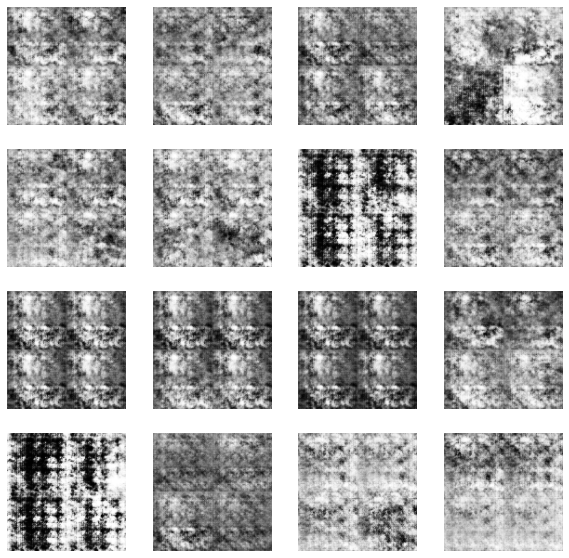

Time for epoch 200 is 16.203378438949585 sec
Sum of losses among batches for epoch 200 is 158.0619659423828


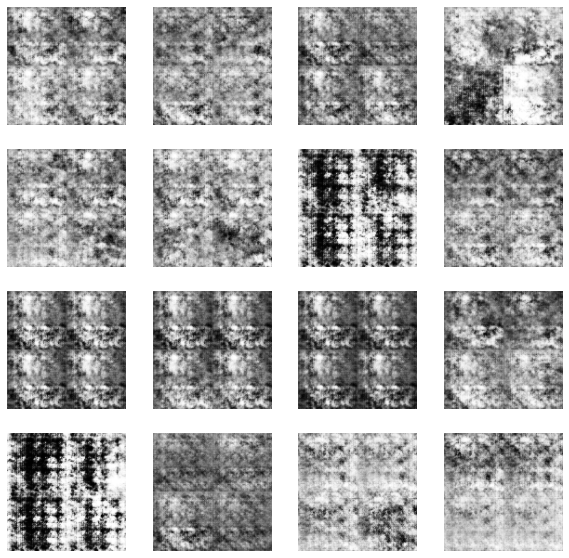

In [ ]:
train(dataset_A, dataset_B, EPOCHS)

### Восстановим checkpoint

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/checkpoints/"

ckpt-68.data-00000-of-00001  ckpt-68.index


In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint" /content/training_checkpoints/checkpoint

cp: cannot stat '/content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint': No such file or directory


In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/checkpoints/ckpt-68.data-00000-of-00001" /content/training_checkpoints/ckpt-68.data-00000-of-00001

In [ ]:
!cp "/content/drive/My Drive/Colab Notebooks/checkpoints/ckpt-68.index" /content/training_checkpoints/ckpt-68.index

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Проверим результат


### Восстановим последнюю контрольную точку

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Скачаем и порежем картинку картинку

In [ ]:
i = 3
image_url = DOMAIN_A_URL.format(i)
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
width, height = img.size
n = height // S
m = width // S

In [ ]:
generated_batch = generator(split_image(img, S), training=False)

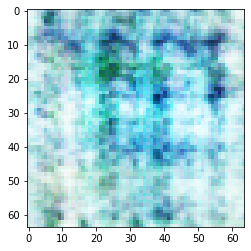

In [ ]:
generated_batch[0]
im = Image.fromarray(((generated_batch[0] * 255).numpy()).astype('uint8'), 'RGB')
plt.imshow(im)

In [ ]:
res = Image.new('RGB', (width, height))
for i in range(n):
    for j in range(m):
        im = Image.fromarray(((generated_batch[i * m + j] * 255).numpy()).astype('uint8'), 'RGB')
        res.paste(im, (j * S, i * S))

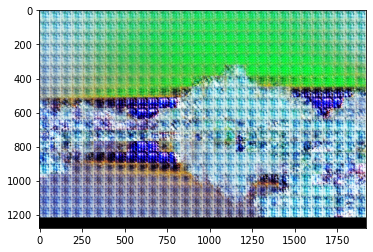

In [ ]:
plt.imshow(res)

In [ ]:
res.save('./resultv3_2200_K40T13.jpg')

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!cp resultv3_2200_K40T13.jpg "drive/My Drive"

In [ ]:
!cp /content/training_checkpoints/ckpt-133.data-00000-of-00001 "drive/My Drive/"

In [ ]:
!cp /content/training_checkpoints/ckpt-133.index "drive/My Drive/"